# EDA & Preprocessing for Regression Dataset

## Setup & Imports

In [35]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(project_root)

c:\Users\monik\OneDrive\Pulpit\ZUM\Projekt\bagging-boosting-stacking-study


In [ ]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.style  
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from scipy.stats import skew
from scipy.stats.mstats import winsorize

from bagging_boosting_stacking_study.data.loaders import load_dataset

# dark theme across plots
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")

SEED = 333

## 1. Load Data

In [37]:
df = load_dataset("airfoil_self_noise")

## 2. Initial Data Inspection

In [38]:
# Summary of dataset dimensions
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Overview of each column’s data type and counts of non-null entries
print("\nDataFrame info:")
df.info()

# Missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
if missing_values.sum() == 0:
    print("No missing values found.")
else:
    display(missing_values[missing_values > 0])

# Check for duplicated rows
duplicated_rows = df.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicated_rows}")

Dataset contains 1503 rows and 6 columns.

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   f           1503 non-null   int64  
 1   alpha       1503 non-null   float64
 2   c           1503 non-null   float64
 3   U_infinity  1503 non-null   float64
 4   delta       1503 non-null   float64
 5   SSPL        1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB

Missing Values:
No missing values found.

Number of duplicated rows: 0


## 3. Univariate Descriptions

In [39]:
# The column SSPL - sound pressure level (dB) is the target columns so I will change its name to 'target'ArithmeticError
df.rename(columns={'SSPL': 'target'}, inplace=True)
display(df)

,f,alpha,c,U_infinity,delta,target
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [40]:
# Stats like: mean, std, min, max and quartiles for numeric columns

desc_stats = df.describe().T
display(desc_stats)

,count,mean,std,min,25%,50%,75%,max
f,1503.0,2886.380572,3152.573137,200.000000,800.000000,1600.000000,4000.000000,20000.000000
alpha,1503.0,6.782302,5.918128,0.000000,2.000000,5.400000,9.900000,22.200000
c,1503.0,0.136548,0.093541,0.025400,0.050800,0.101600,0.228600,0.304800
U_infinity,1503.0,50.860745,15.572784,31.700000,39.600000,39.600000,71.300000,71.300000
delta,1503.0,0.011140,0.013150,0.000401,0.002535,0.004957,0.015576,0.058411
target,1503.0,124.835943,6.898657,103.380000,120.191000,125.721000,129.995500,140.987000


In [41]:
# Skewness and kurtosis
skewness = df.skew()
kurtosis = df.kurtosis()

iqr_outlier_counts = {}
z_outlier_counts = {}
outlier_index_info = {}

# Detect outliers per column
for col in df.columns:
    series = df[col]

    # IQR-based outliers
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    iqr_mask = (series < lower) | (series > upper)
    iqr_indices = series.index[iqr_mask].tolist()
    iqr_outlier_counts[col] = len(iqr_indices)

    # Z-score-based outliers (|z| > 3)
    mean, std = series.mean(), series.std()
    z_scores = (series - mean) / std
    z_mask = np.abs(z_scores) > 3
    z_indices = series.index[z_mask].tolist()
    z_outlier_counts[col] = len(z_indices)

    # Index details
    outlier_index_info[col] = {
        "iqr_indices": iqr_indices,
        "z_indices": z_indices
    }

# Summary df
summary_df = pd.DataFrame({
    "skewness": skewness,
    "kurtosis": kurtosis,
    "iqr_outliers": pd.Series(iqr_outlier_counts),
    "z_outliers": pd.Series(z_outlier_counts)
}).round(2)

# Display summary
print("Skewness, Kurtosis & Outlier Counts:\n")
display(summary_df)

Skewness, Kurtosis & Outlier Counts:



,skewness,kurtosis,iqr_outliers,z_outliers
f,2.14,5.71,86,44
alpha,0.69,-0.41,30,0
c,0.46,-1.04,0,0
U_infinity,0.24,-1.56,0,0
delta,1.70,2.22,124,32
target,-0.42,-0.31,4,2


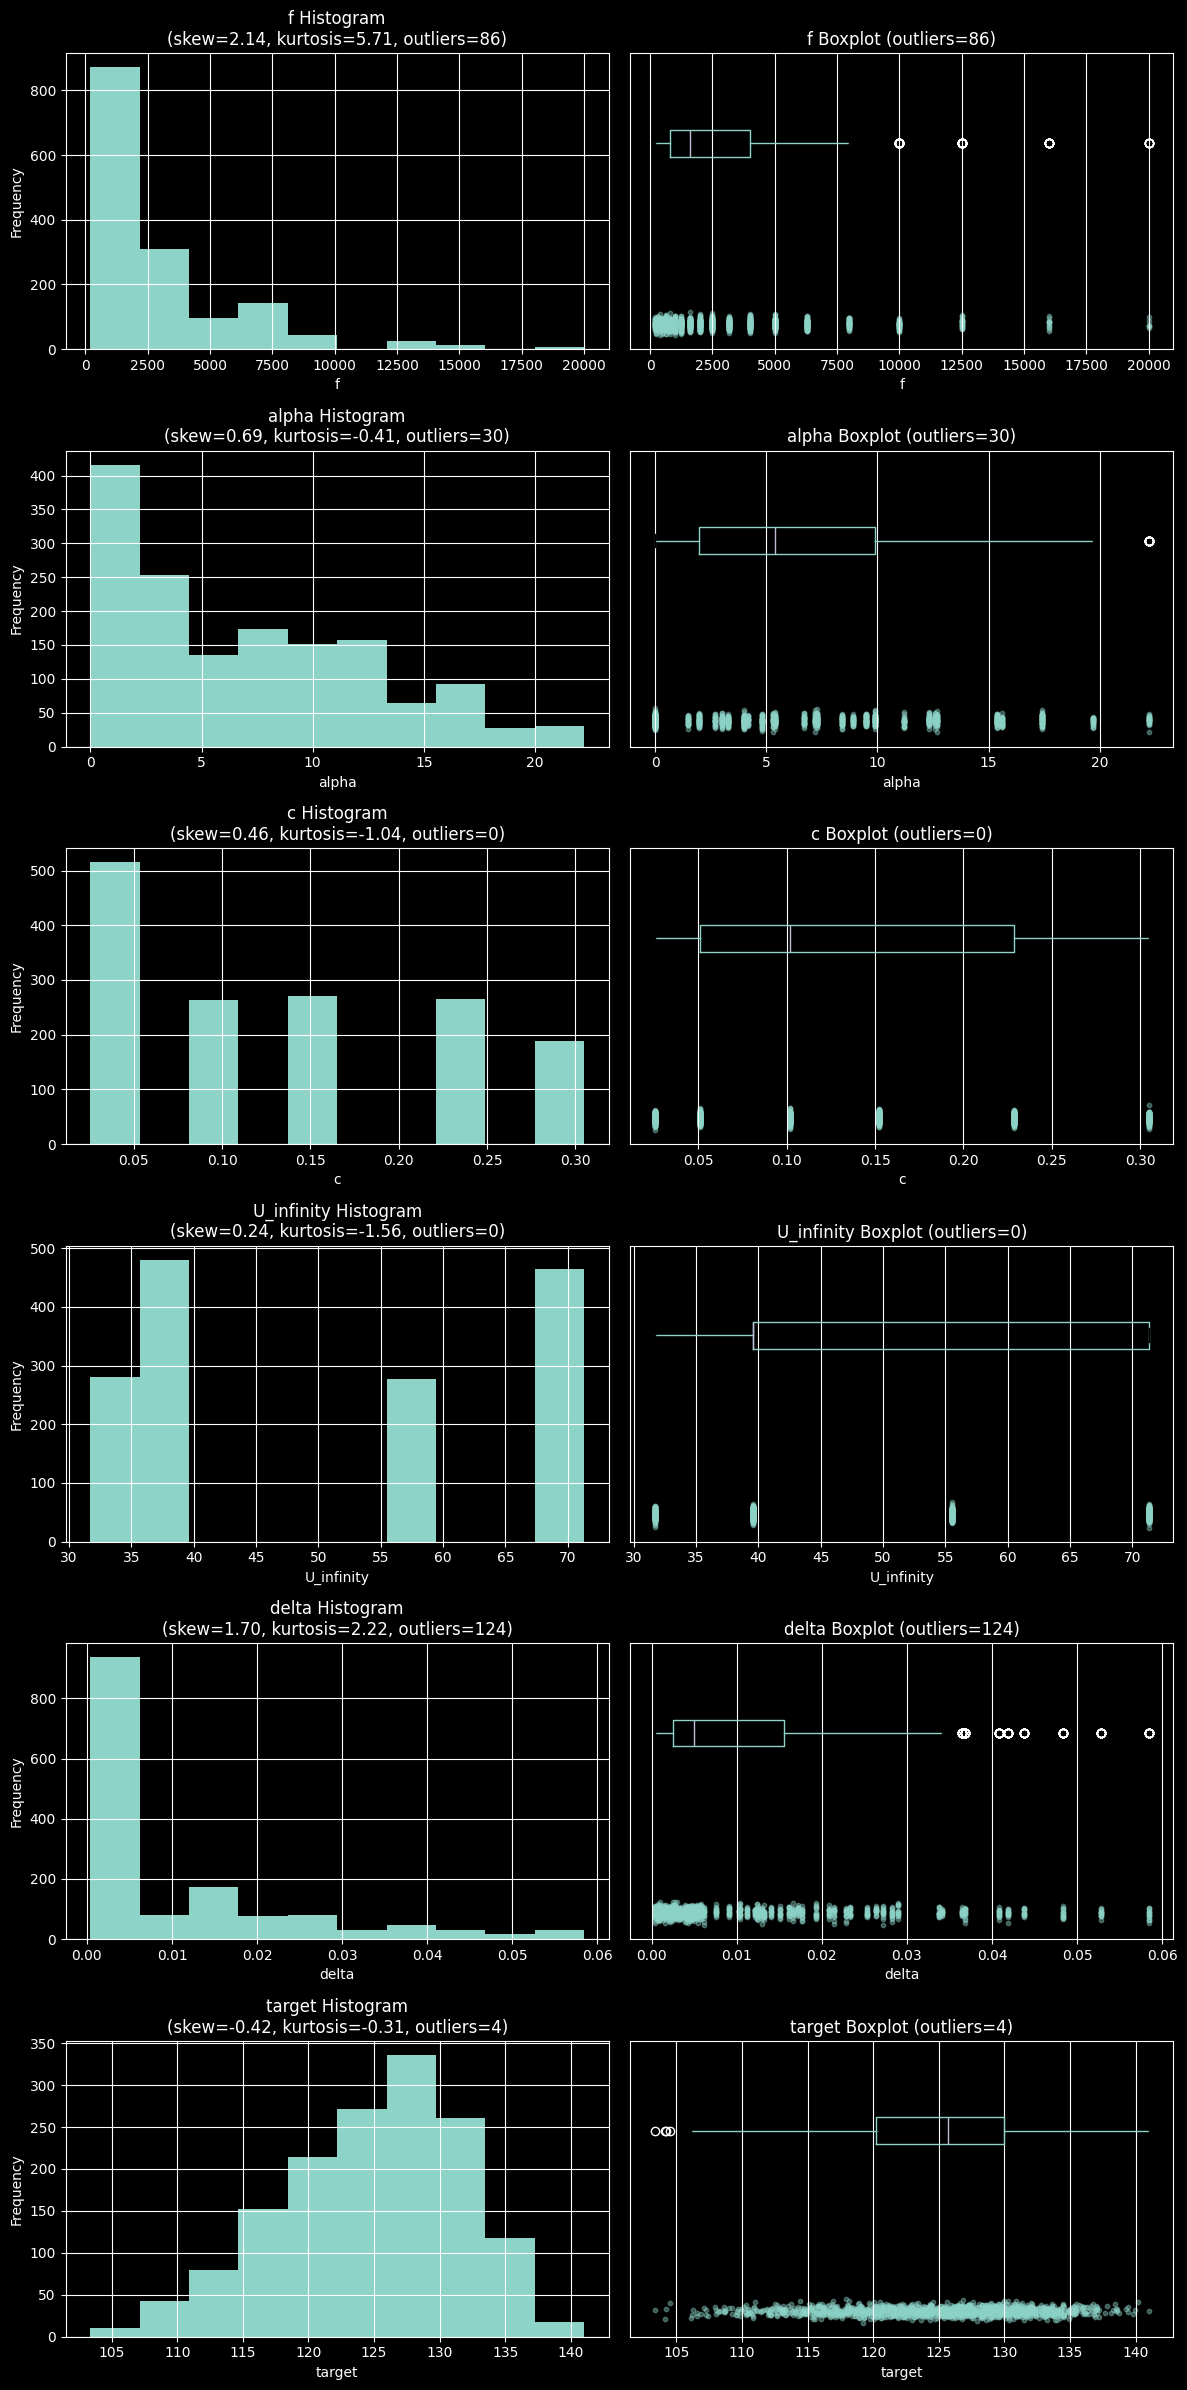

In [42]:
features = list(df.columns)
n = len(features)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n))

for i, col in enumerate(features):
    skew_val  = skewness[col]
    kurt_val  = kurtosis[col]
    out_count = iqr_outlier_counts[col]

    # Histogram with skewness & kurtosis
    ax_hist = axes[i, 0]
    df[col].hist(ax=ax_hist)
    ax_hist.set_title(
        f"{col} Histogram\n"
        f"(skew={skew_val:.2f}, kurtosis={kurt_val:.2f}, outliers={out_count})"
    )
    ax_hist.set_xlabel(col)
    ax_hist.set_ylabel("Frequency")

    # Boxplot + jitter
    ax_box = axes[i, 1]
    df.boxplot(column=col, ax=ax_box, vert=False, showfliers=True)
    y_jitter = np.random.normal(loc=0, scale=0.02, size=len(df))
    ax_box.scatter(df[col], y_jitter, alpha=0.4, s=10)
    ax_box.set_title(f"{col} Boxplot (outliers={out_count})")
    ax_box.set_xlabel(col)
    ax_box.set_yticks([])

plt.tight_layout()
plt.show()

## 4. Outlier & Missing-Value Analysis

In [43]:
df.isnull().sum()

f             0
alpha         0
c             0
U_infinity    0
delta         0
target        0
dtype: int64

There are no missing values in df.

In [44]:
# Function to display full rows for outliers of a given column
def show_outlier_rows(column_name):
    idxs = outlier_index_info.get(column_name, {})
    if not idxs or (not idxs["iqr_indices"] and not idxs["z_indices"]):
        print(f"No outliers detected for '{column_name}'.")
        return

    if idxs["iqr_indices"]:
        print(f"\nFull rows for IQR outliers in '{column_name}':")
        display(df.loc[idxs["iqr_indices"]])

    if idxs["z_indices"]:
        print(f"\nFull rows for Z-score outliers in '{column_name}':")
        display(df.loc[idxs["z_indices"]])

In [45]:
show_outlier_rows('f')


Full rows for IQR outliers in 'f':


,f,alpha,c,U_infinity,delta,target
11,10000,0.0,0.3048,71.3,0.002663,115.391
12,12500,0.0,0.3048,71.3,0.002663,112.241
13,16000,0.0,0.3048,71.3,0.002663,108.721
27,10000,0.0,0.3048,55.5,0.002831,113.076
28,12500,0.0,0.3048,55.5,0.002831,111.076
...,...,...,...,...,...,...
1280,10000,0.0,0.1016,39.6,0.001463,119.561
1293,10000,0.0,0.1016,31.7,0.001501,115.893
1305,10000,3.3,0.1016,71.3,0.002028,116.694
1318,10000,3.3,0.1016,55.5,0.002211,115.659



Full rows for Z-score outliers in 'f':


,f,alpha,c,U_infinity,delta,target
12,12500,0.0,0.3048,71.3,0.002663,112.241
13,16000,0.0,0.3048,71.3,0.002663,108.721
28,12500,0.0,0.3048,55.5,0.002831,111.076
47,12500,0.0,0.3048,39.6,0.003101,109.619
78,12500,1.5,0.3048,71.3,0.003367,109.222
79,16000,1.5,0.3048,71.3,0.003367,106.582
96,12500,1.5,0.3048,39.6,0.003921,106.111
173,12500,4.0,0.3048,71.3,0.004978,107.405
198,12500,0.0,0.2286,71.3,0.002143,117.624
199,16000,0.0,0.2286,71.3,0.002143,114.984


In [46]:
show_outlier_rows('alpha')


Full rows for IQR outliers in 'alpha':


,f,alpha,c,U_infinity,delta,target
1210,315,22.2,0.0254,71.3,0.021418,115.857
1211,400,22.2,0.0254,71.3,0.021418,117.927
1212,500,22.2,0.0254,71.3,0.021418,117.967
1213,630,22.2,0.0254,71.3,0.021418,120.657
1214,800,22.2,0.0254,71.3,0.021418,123.227
1215,1000,22.2,0.0254,71.3,0.021418,134.247
1216,1250,22.2,0.0254,71.3,0.021418,140.987
1217,1600,22.2,0.0254,71.3,0.021418,131.817
1218,2000,22.2,0.0254,71.3,0.021418,127.197
1219,2500,22.2,0.0254,71.3,0.021418,126.097


In [47]:
show_outlier_rows('c')

No outliers detected for 'c'.


In [48]:
show_outlier_rows('U_infinity')

No outliers detected for 'U_infinity'.


In [49]:
show_outlier_rows('delta')


Full rows for IQR outliers in 'delta':


,f,alpha,c,U_infinity,delta,target
693,200,12.6,0.1524,71.3,0.048316,128.354
694,250,12.6,0.1524,71.3,0.048316,129.744
695,315,12.6,0.1524,71.3,0.048316,128.484
696,400,12.6,0.1524,71.3,0.048316,127.094
697,500,12.6,0.1524,71.3,0.048316,121.664
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224



Full rows for Z-score outliers in 'delta':


,f,alpha,c,U_infinity,delta,target
709,200,12.6,0.1524,39.6,0.058411,114.750
710,250,12.6,0.1524,39.6,0.058411,115.890
711,315,12.6,0.1524,39.6,0.058411,116.020
712,400,12.6,0.1524,39.6,0.058411,115.910
713,500,12.6,0.1524,39.6,0.058411,114.900
714,630,12.6,0.1524,39.6,0.058411,116.550
715,800,12.6,0.1524,39.6,0.058411,116.560
716,1000,12.6,0.1524,39.6,0.058411,114.670
717,1250,12.6,0.1524,39.6,0.058411,112.160
718,1600,12.6,0.1524,39.6,0.058411,110.780


In [50]:
show_outlier_rows('target')


Full rows for IQR outliers in 'target':


,f,alpha,c,U_infinity,delta,target
722,4000,12.6,0.1524,39.6,0.058411,104.500
723,5000,12.6,0.1524,39.6,0.058411,104.130
724,6300,12.6,0.1524,39.6,0.058411,103.380
1502,6300,15.6,0.1016,39.6,0.052849,104.204



Full rows for Z-score outliers in 'target':


,f,alpha,c,U_infinity,delta,target
723,5000,12.6,0.1524,39.6,0.058411,104.13
724,6300,12.6,0.1524,39.6,0.058411,103.38


In [51]:
# Domain-based removal thresholds
thresholds = {
    'f': (100, 10000),            # frequency in Hz
    'alpha': (-20, 20),           # angle of attack in degrees
    'c': (0.01, 0.5),             # chord length in meters
    'U_infinity': (1, 100),       # free-stream velocity in m/s
    'delta': (0.001, 0.1),        # thickness in meters
    'target': (20, 200)           # SPL in dB
}

# Mask for impossible values
mask_error = pd.Series(False, index=df.index)
for col, (low, high) in thresholds.items():
    mask_error |= df[col] < low
    mask_error |= df[col] > high

# Split out erroneous rows vs plausible
df_errors = df[mask_error].copy()
df_plausible = df[~mask_error].copy()

# Winsorize genuine extremes in plausible subset (1st–99th percentile)
df_wins = df_plausible.copy()
for col in df_plausible.columns:
    lower = df_plausible[col].quantile(0.01)
    upper = df_plausible[col].quantile(0.99)
    df_wins[col] = np.clip(df_plausible[col], lower, upper)


print(f"Erroneous rows detected and removed: {len(df_errors)}")
display(df_errors.head())

print("\nPlausible data summary (before winsorizing):")
display(df_plausible.describe().round(2))

print("\nPlausible data summary (after winsorizing 1–99%):")
display(df_wins.describe().round(2))

Erroneous rows detected and removed: 201


,f,alpha,c,U_infinity,delta,target
12,12500,0.0,0.3048,71.3,0.002663,112.241
13,16000,0.0,0.3048,71.3,0.002663,108.721
28,12500,0.0,0.3048,55.5,0.002831,111.076
47,12500,0.0,0.3048,39.6,0.003101,109.619
78,12500,1.5,0.3048,71.3,0.003367,109.222



Plausible data summary (before winsorizing):


,f,alpha,c,U_infinity,delta,target
count,1302.00,1302.00,1302.00,1302.00,1302.00,1302.00
mean,2396.37,7.11,0.15,50.74,0.01,124.46
std,2316.05,5.54,0.09,15.54,0.01,6.70
min,200.00,0.00,0.03,31.70,0.00,103.38
25%,630.00,2.70,0.05,39.60,0.00,120.03
50%,1600.00,6.70,0.15,39.60,0.01,125.37
75%,3150.00,11.20,0.23,71.30,0.02,129.47
max,10000.00,19.70,0.30,71.30,0.06,140.16



Plausible data summary (after winsorizing 1–99%):


,f,alpha,c,U_infinity,delta,target
count,1302.00,1302.00,1302.00,1302.00,1302.00,1302.00
mean,2396.37,7.11,0.15,50.74,0.01,124.46
std,2316.05,5.54,0.09,15.54,0.01,6.61
min,200.00,0.00,0.03,31.70,0.00,108.04
25%,630.00,2.70,0.05,39.60,0.00,120.03
50%,1600.00,6.70,0.15,39.60,0.01,125.37
75%,3150.00,11.20,0.23,71.30,0.02,129.47
max,10000.00,19.70,0.30,71.30,0.06,137.23


## Conclusion for outliers

- **Erroneous Data Removal**  
  201 rows are to be dropped because they violated domain‐specific bounds (e.g. negative chord lengths, unrealistically high velocities), preventing measurement errors from biasing our model.

- **Winsorization of Valid Extremes**  
  The remaining dataset should be winsorized at the 1st–99th percentile to cap the influence of extreme—but physically plausible—values, preserving all observations while limiting their leverage in parametric models.

- **Robust Modeling Alternative**  
  For tree‐based or other outlier‐resistant algorithms, we can skip winsorization and rely on the model’s inherent robustness, or apply light transformations (e.g. log, Box–Cox) to heavily skewed features.


## 5. Correlation Analysis

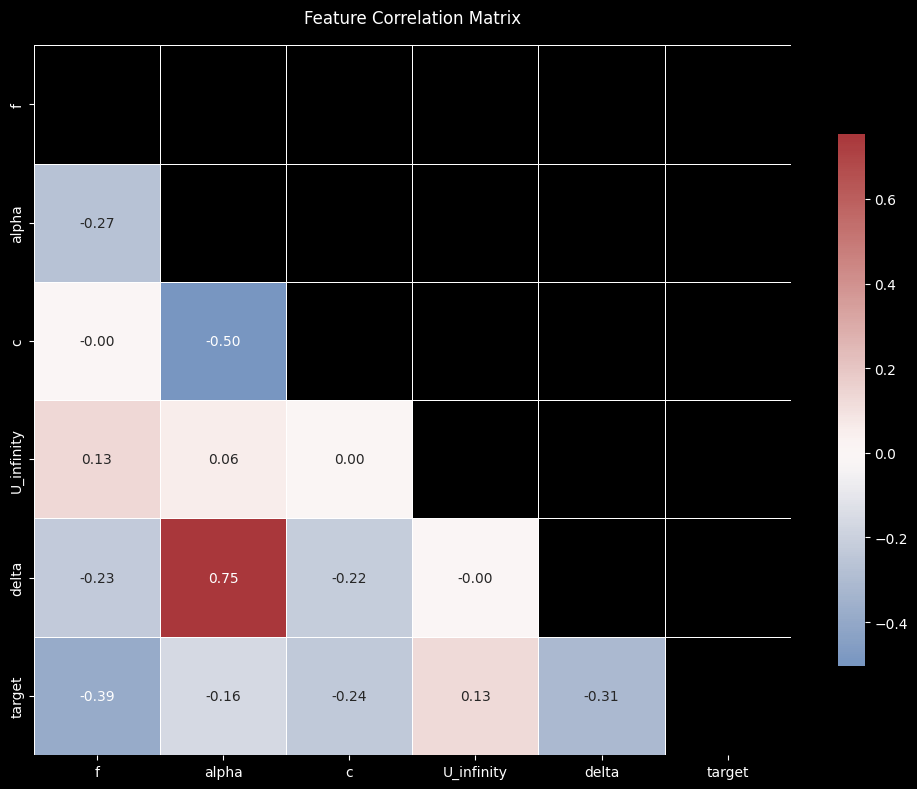

In [52]:
# Correlation matrix
corr = df.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    ax=ax
)

ax.set_title("Feature Correlation Matrix", color="white", pad=16)
plt.tight_layout()
plt.show()

## Correlation Matrix Insights

Quick interpretation of the pairwise correlations computed above:

| Feature Pair        | Corr  | Interpretation                            |
|---------------------|-------|-------------------------------------------|
| **(alpha) & delta**   | +0.75 | **High collinearity**—angle of attack and thickness move together.  |
| **α & c**           | –0.50 | Moderate inverse relation—larger angles tend to go with smaller chords.  |
| **f & target**      | –0.39 | Moderate negative—higher frequency → lower SPL.                    |
| **delta & target**      | –0.31 | Moderate negative—thicker airfoil → lower SPL.                     |
| **U_infinity & target**     | +0.13 | Very weak positive—free‐stream velocity has small direct effect.   |
| **alpha, c & target**   | –0.16, –0.24 | Weak correlations—angle and chord aren’t strong standalone predictors. |

---

### What to do next

1. **Address multicollinearity**  
   - **alpha & delta (0.75)** are highly correlated. Options:  
     - **Droping one** 
     - **Combining** into a single feature (e.g. principal component)  
     - **Using regularized models** (Ridge/Lasso) or tree‐based methods that tolerate collinearity  

2. **Feature selection**  
   - **Low-impact variables** (|corr| < 0.3) like alpha, c, and U_infinity could be:  
     - **Dropped** if they add noise  
     - **Engineered** (interactions, non-linear transforms) to boost predictive power  

3. **Transform highly skewed predictors**  
   - We saw earlier that `f` and `delta` were skewed. A log or Box–Cox transform can also help linear models capture their relationship with SPL.

4. **Modeling strategy**  
   - **Linear/parametric**:  
     - Drop or combine collinear features  
     - Winsorize or transform skewed features  
     - Regularize (Ridge/Lasso) to shrink redundant coefficients  
   - **Tree-based/ensemble**:  
     - Less sensitive to outliers or multicollinearity  
     - We can often include all features directly (but you may still drop very noisy ones)


In [53]:
# VIF analysis
X = df[['f','alpha','c','U_infinity','delta']].copy()

# add constant for intercept
X['intercept'] = 1.0

# calculate VIF for each feature
vif_data = []
for i, col in enumerate(X.columns):
    vif = variance_inflation_factor(X.values, i)
    vif_data.append((col, vif))

vif_df = pd.DataFrame(vif_data, columns=['feature', 'VIF'])
print(vif_df.sort_values('VIF', ascending=False))

      feature        VIF
5   intercept  19.283769
1       alpha   3.441658
4       delta   2.532127
2           c   1.510754
0           f   1.144444
3  U_infinity   1.041698


### Why Multicollinearity Matters for Bagging / Boosting / Stacking

- **Bagging**  
  - Tree‐based bagged ensembles are **largely insensitive** to multicollinearity, since each tree splits on one feature at a time.  
  - However, highly correlated predictors can still lead to **redundant splits**, increasing model complexity without improving performance.  
  - **Action**: We _can_ keep both features, but dropping or combining collinear variables may reduce training time and simplify interpretation.

- **Boosting**  
  - Boosted trees also tolerate collinearity, but share the same risk of redundant splits across sequential learners.  
  - Collinear inputs can make the boosting process **slower to converge** and may cause over‐fitting on noisy signals.  
  - **Action**: Consider dropping or PCA‐combining highly correlated features to speed up training and improve generalization.

- **Stacking**  
  - When stacking linear base learners (e.g. Ridge, Lasso) with tree‐based learners, collinearity can **destabilize** the linear models’ coefficient estimates.  
  - A common practice is to create two parallel stacks:  
    1. **“Reduced” stack** using dropped collinear features for cleaner linear fits  
    2. **“Full” stack** feeding all features into tree ensembles  
  - The meta‐learner can then learn to weight each stack appropriately, balancing bias and variance.

---

**Bottom Line**  
- For **pure tree‐based** bagging or boosting, we _may_ leave collinear features in place, but we'll gain speed by removing or combining them.  
- For **linear** or **stacked** components, reducing multicollinearity is crucial to ensure stable, interpretable models and robust ensemble blending.  


## 6. Multivariate Exploration

In [54]:
corr = df.corr().abs()
# get upper triangle without diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
tri_corr = corr.where(mask)

# find the top 4 feature‐feature correlations
top_pairs = (
    tri_corr
    .unstack()
    .dropna()
    .sort_values(ascending=False)
    .head(4)
    .reset_index()
    .rename(columns={0: 'corr'})
    [['level_0','level_1','corr']]
)
print("Top feature‐feature correlations:")
print(top_pairs.to_string(index=False))

# find top 3 features most correlated with target (absolute value)
top_with_target = (
    corr['target']
    .drop('target')
    .sort_values(ascending=False)
    .head(4)
    .reset_index()
    .rename(columns={'index':'feature','target':'corr'})
)
print("\nTop features correlated with target:")
print(top_with_target.to_string(index=False))


Top feature‐feature correlations:
level_0 level_1     corr
  delta   alpha 0.753394
      c   alpha 0.504868
 target       f 0.390711
 target   delta 0.312670

Top features correlated with target:
feature     corr
      f 0.390711
  delta 0.312670
      c 0.236162
  alpha 0.156108


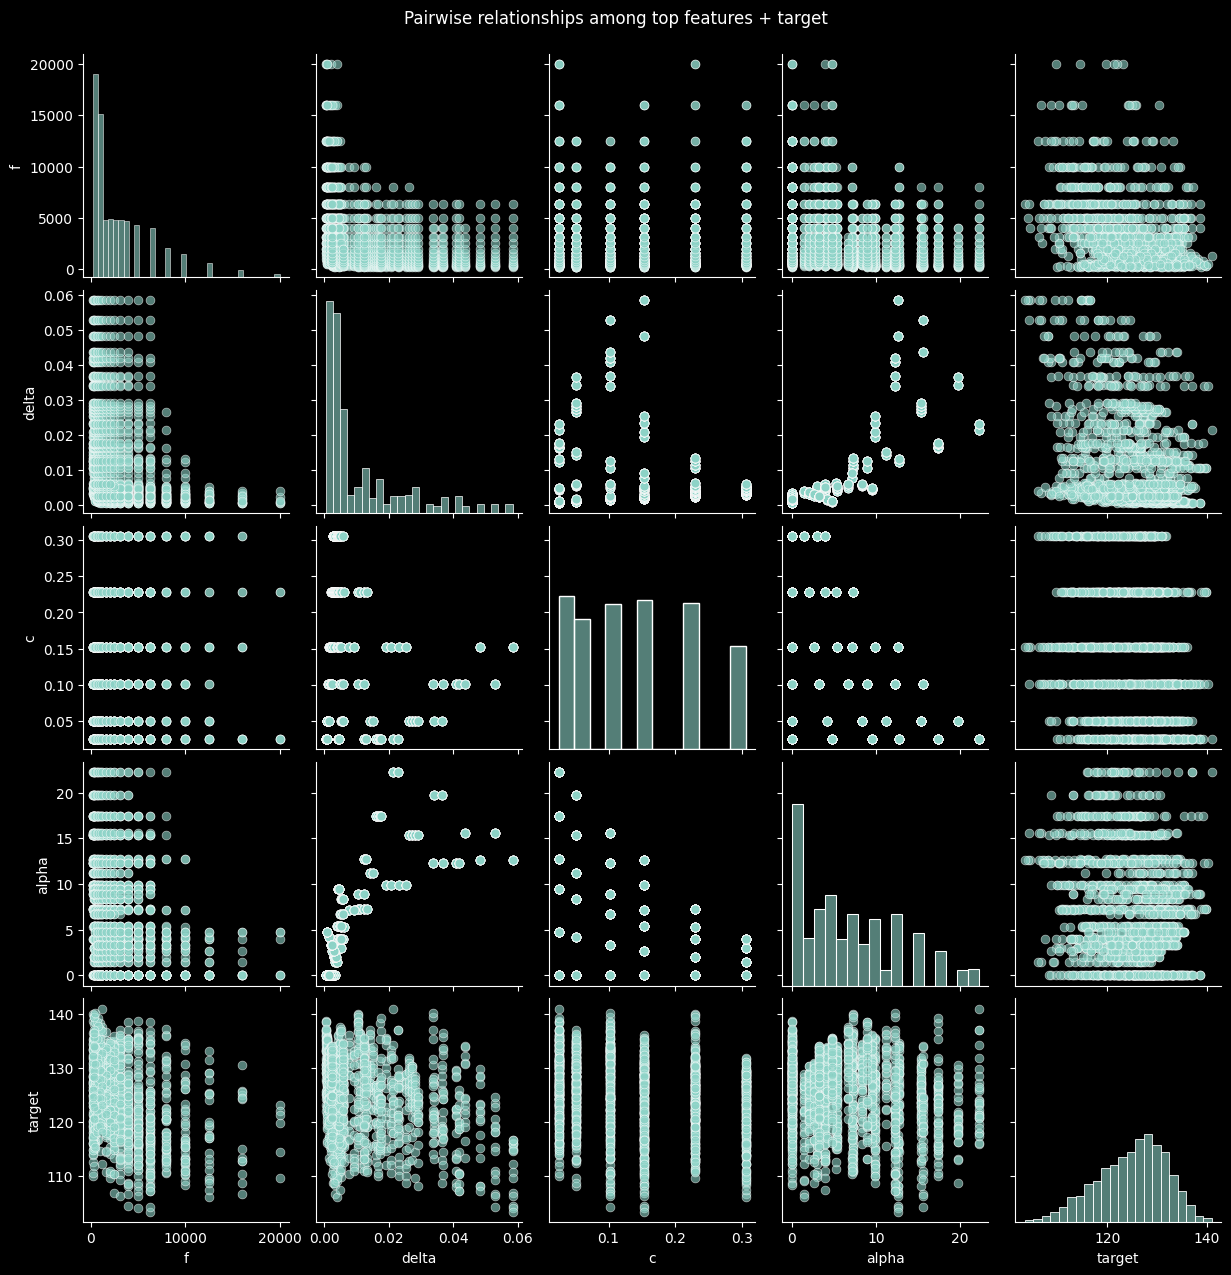

In [55]:
top_feat_list = top_with_target['feature'].tolist()

# Create the pairplot
sns.pairplot(
    df[top_feat_list + ['target']],
    kind="scatter",
    diag_kind="hist",
    plot_kws={"alpha": 0.6, "s": 40, "edgecolor": "white"},
    diag_kws={"alpha": 0.6}
)

plt.suptitle("Pairwise relationships among top features + target", y=1.02)
plt.show()

## Interpreting the Expanded Pairplot (f, delta, c, alpha, target)

### Pairwise Relationships

| Pair                | Pattern & Shape                                                        | Takeaway & Next Step                                    |
|---------------------|------------------------------------------------------------------------|----------------------------------------------------------|
| **f vs. delta**     | Round cloud, no obvious trend                                          | Independent – no need to combine these two features.     |
| **f vs. c**         | Vertical stripes at each chord value, f spread within each stripe      | Experimental design artifact; treat **c** as categorical. |
| **f vs. alpha**     | Vertical “bands” at discrete alpha values, f spread uniformly              | alpha and f are uncorrelated; no action needed.             |
| **f vs. target**    | Clear downward slope (higher f → lower SPL)                            | Strong negative effect (corr≈–0.39); include log f or f. |
| **delta vs. c**     | Slight negative tilt: thicker foils often have smaller chords          | Weak inverse relation (corr≈–0.22); watch VIF if linear. |
| **delta vs. alpha** | Tight upward trend—thicker foils tested at higher alpha (corr≈+0.75)       | High collinearity; consider dropping or PCA’ing one.    |
| **delta vs. target**| Gentle downward slope (thicker → slightly less noise, corr≈–0.31)      | Modest effect; keep as numeric predictor.               |
| **c vs. alpha**     | Discrete α clouds for each c, no clear slope                           | Largely independent; encode **c** categorically.        |
| **c vs. target**    | Vertical stripes with slight downward drift at larger c                | Small negative effect; treat **c** as factor or dummy.  |
| **alpha vs. target**| Mild downward trend (higher alpha → lower SPL, corr≈–0.16)                 | Weak effect; may need interaction or non‐linear term.    |



### Conclusions 

1. Similar conclusions to insights on correlation matrix regarding high corr **delta ↔ alpha**.*

2. **Feature Types & Transforms**  
   - **c**: treat as categorical (one-hot or embedding).  
   - **f** & **delta**: highly skewed → apply `log1p` or Box–Cox before linear methods.  
   - **alpha**: discrete angles could be one-hot‐encoded or left numeric if order matters.

3. **Interaction Candidates**  
   - The slight curves in **delta–target** and **f–target** scatter suggest adding simple polynomial (e.g. `delta²`) or interaction terms (e.g. `f × delta`).

4. **Modeling Strategy**  
   - **Tree‐based (bagging/boosting)**: naturally handle non-linear & interactions—no need to drop collinear features, but we can still transform skewed ones for stability.  
   - **Linear/stacked**: we **must** address multicollinearity and heteroscedasticity—use regularization (Ridge/Lasso) by droping/combining collinear inputs, and transforming skewed features.

---

**Bottom Line:**  
- **Frequency** is our strongest single predictor (negative linear trend).  
- **Thickness** and **angle of attack** are deeply intertwined — we can collapse or remove one for linear models.  
- **Chord length** is discrete—encode appropriately. 


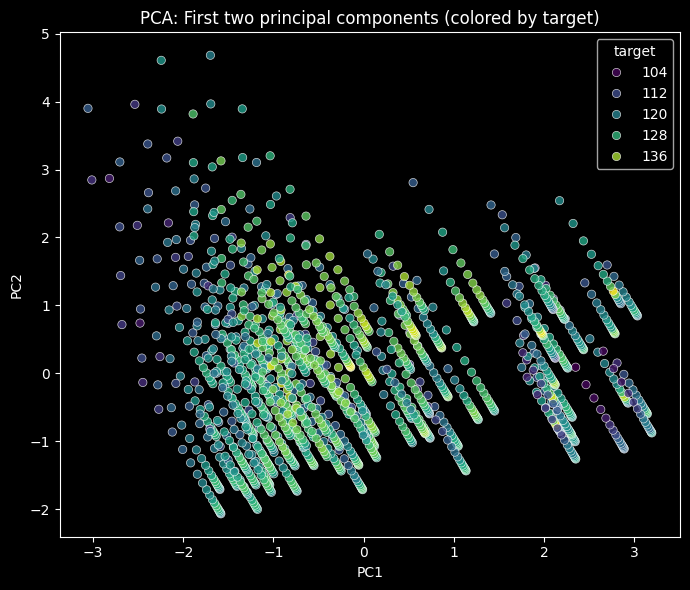

In [56]:
# 3. PCA projection & visualization

features = [c for c in df.columns if c != 'target']
X = StandardScaler().fit_transform(df[features])

pca = PCA(n_components=2, random_state=SEED)
pcs = pca.fit_transform(X)
pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'])
pc_df['target'] = df['target'].values

plt.figure(figsize=(7,6))
sns.scatterplot(x='PC1', y='PC2', hue='target', data=pc_df, palette='viridis', alpha=0.8)
plt.title("PCA: First two principal components (colored by target)")
plt.legend(title='target', loc='best')
plt.tight_layout()
plt.show()

## PCA Conclusion

1. **PC1 Captures the SPL Gradient**  
   - As we move **rightward along PC1**, the color of the points smoothly shifts from deep purple (low SPL ≈104 dB) to light green (high SPL ≈136 dB).  
   - This tells us that the first principal component is effectively a **one‐dimensional summary** of the feature combination most responsible for changes in noise level.

2. **No Discrete Clusters by SPL**  
   - SPL values form a **continuous gradient** rather than tight groups. There aren’t separate “low-noise” vs. “high-noise” blobs, but rather a manifold along PC1.  
   - This suggests our SPL response is driven by a smooth interplay of aerodynamic variables (no distinct regime shift).

3. **Experimental “Stripes” in the Manifold**  
   - We can see faint **parallel bands** running diagonally. These correspond to the discrete chord lengths and angle-of-attack settings in the original experiment.  
   - They don’t represent different SPL behaviors—just the fact that you repeatedly sampled the same geometries across varying conditions.

4. **PC2 Is Secondary Variation**  
   - The vertical spread (PC2) shows residual variation that **doesn’t track SPL** as strongly.  
   - PC2 likely encodes orthogonal experimental factors (e.g. minor interactions of thickness vs. velocity) that have only a small effect on noise.

---

### What This Implies

- **Dimension Reduction**  
  We could use **PC1 alone** as a single predictor for SPL (or include PC1 + PC2 in a regression) and capture most of the signal.

- **Model Choice**  
  Because SPL varies **continuously** along PC1, even a simple linear model on PC1 should perform surprisingly well. Tree-based ensembles could then add nuance by capturing the slight non‐linearity encoded in PC2.

- **Feature Engineering**  
  The curved shape of the manifold (not perfectly straight) hints that there are **non-linear interactions** in the original features—worth preserving via polynomial or interaction terms if you build a purely linear model.

Overall, this PCA plot confirms that a **single dominant latent direction** explains most of the variability in airfoil noise, and that SPL behaves as a smooth function along that axis.  


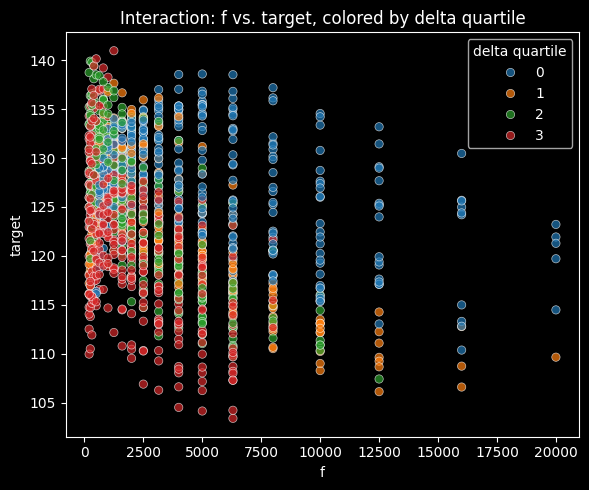

In [57]:
# Interaction effect example: feature‐target stratified by another feature

# pick the top two features correlated with target
fA = top_with_target.loc[0,'feature']
fB = top_with_target.loc[1,'feature']

# bin fB into quartiles
df['B_quartile'] = pd.qcut(df[fB], q=4, labels=False)
plt.figure(figsize=(6,5))
sns.scatterplot(x=fA, y='target', hue='B_quartile', data=df, palette='tab10', alpha=0.7)
plt.title(f"Interaction: {fA} vs. target, colored by {fB} quartile")
plt.legend(title=f"{fB} quartile", loc='best')
plt.tight_layout()
plt.show()

## Interaction Plot Conclusion: Frequency vs. SPL by Thickness Quartile

1. **Overall Trend (f → SPL)**  
   - Across all thicknesses, **higher frequency (f)** corresponds to **lower sound pressure level (SPL)**—consistent with our negative correlation (~–0.39).

2. **Thickness as a Moderator**  
   - **Blue points (quartile 0, thinnest foils)** lie at the **top** of each vertical stripe and show the **steepest** downward slope. Thin foils generate the **highest SPL** at low f and drop off quickly as f increases.  
   - **Red points (quartile 3, thickest foils)** cluster at the **bottom** and follow a **flatter** slope. Thick foils produce **consistently lower SPL**, and their noise level is **less sensitive** to frequency changes.

3. **Intermediate Quartiles**  
   - Quartiles 1 & 2 (orange/green) lie between these extremes, showing a **graded transition** rather than abrupt shifts—indicating a smooth interaction effect.

4. **Implication: Add an Interaction Term**  
   - The fact that the **slope of f→SPL changes with foil thickness** is a clear sign of an interaction effect.  
   - **Model equation** suggestion:  
     ```python
     SPL ≈ β0 + β1·f + β2·delta + β3·(f × delta) + ε
     ```  
   - A tree‐based model will capture this automatically, but for linear or regularized regression we should **explicitly include** the `f * delta` term.

---

**Bottom line:**  
Foil **thickness** not only has its own effect on SPL, but also **modulates** the frequency–SPL relationship. Explicitly modeling this interaction will yield better fit and clearer physical insights.  


## 7. Feature Engineering Plan

### 1. Transformations for Skewed Distributions
- **Log1p Transform**  
  - **Columns**: `f`, `delta`  
  - **Rationale**: Both frequency and thickness are right‐skewed. Log‐transforming will compress long tails, stabilize variance, and help linear‐based learners (e.g. Ridge) fit more robustly.  
- **Power / Box–Cox Transform (optional)**  
  - **Columns**: `target` (SPL) if heteroscedasticity remains after log  
  - **Rationale**: If residuals from initial models show non‐constant variance, a mild power transform can improve normality assumptions.

### 2. Scaling & Normalization
- **StandardScaler**  
  - **Use for**: Linear base learners in stacking (Ridge, Lasso, SVR)  
  - **Rationale**: Zero‐mean unit‐variance scaling ensures regularization penalties treat each feature comparably.  
- **No Scaling Required**  
  - **For**: Tree‐based models (RandomForest, XGBoost, LightGBM)  
  - **Rationale**: Tree splits are invariant to monotonic transforms and feature scale.

### 3. Derived Features
- **Interaction Terms**  
  - `f × delta`  
  - `f × alpha`  
  - **Rationale**: We observed that thickness moderates the frequency→SPL slope. Explicit interaction captures this in linear or boosting models.  
- **Polynomial Terms**  
  - `delta²`, `alpha²`, `f²`  
  - **Rationale**: Curvature in the scatterplots suggests non‐linear effects; polynomial terms allow linear models to approximate these curves.  
- **PCA Components**  
  - **PC1** (and optionally PC2) from scaled `[f, delta, alpha, U_infinity, c]`  
  - **Rationale**: PC1 strongly summarizes SPL variation; a simple model on PCs can serve as a baseline or meta‐feature in stacking.  
- **Cluster Labels**  
  - **K‐Means (k=4)** clusters in PCA space  
  - **Rationale**: Engineered categorical segment captures regime behavior (e.g. “high noise vs. low noise”). Use as a feature or for stratified modeling.

### 4. Binning & Categorical Encoding
- **Chord (`c`)**  
  - **Encoding**: One‐hot or ordinal (5–7 distinct values)  
  - **Rationale**: Discrete geometries; one‐hot ensures no false ordering.  
- **Angle (`alpha`)**  
  - **Encoding**: Ordinal as numeric, or one‐hot for a few unique angles  
  - **Rationale**: If physical ordering matters (higher alpha → more lift/noise), keep numeric; else one‐hot to avoid assuming linearity.  
- **Rare Category Grouping**  
  - **Threshold**: If any one‐hot level has <5% frequency, group under “Other.”  
  - **Rationale**: Prevents overfitting on infrequent experiment settings.

### 5. Rationale for Bagging / Boosting / Stacking
- **Bagging / Random Forest**  
  - Handles interactions/non‐linearities inherently—no need for heavy polynomial expansion.  
  - But log‐transforms reduce outlier leverage and improve split stability.  
- **Boosting (XGBoost / LightGBM)**  
  - Benefits from interaction features and cluster labels to speed up convergence.  
  - PCA components can serve as monotonic covariates for regularized boosting.  
- **Stacking**  
  - **Linear stack**: uses scaled & transformed features (logs, polynomials, interactions) for interpretable coefficients.  
  - **Tree stack**: uses raw + engineered discrete features (one‐hot c, cluster labels).  
  - Meta‐learner combines their strengths—linear bias + tree variance.


## 8. Preprocessing Pipeline Outline

1. **Domain-Based Outlier Removal**  
   - Define plausible ranges and drop rows outside them:  
     - `f` ∈ [100, 10000] Hz  
     - `alpha` ∈ [–20, 20]°  
     - `c` ∈ [0.01, 0.5] m  
     - `U_infinity` ∈ [1, 100] m/s  
     - `delta` ∈ [0.001, 0.1] m  
     - `target` ∈ [20, 200] dB  
   - Result: remove the 201 “impossible” experiments.

2. **Winsorize Remaining Extremes**  
   - For each numeric feature, cap values at its 1st and 99th percentiles to limit leverage of extreme but valid measurements.

3. **Skew-Reduction Transforms**  
   - Apply `log1p()` to:  
     - **`f`** (frequency)  
     - **`delta`** (thickness)  
   - (Optional) If residual heteroscedasticity remains, consider a mild Box–Cox on `target`.

4. **Multicollinearity Remedy**  
   - **Decision**: drop **`delta`** for any linear pipeline (since `corr(alpha, delta)≈0.75`).  
   - **Alternative**: combine `alpha`+`delta` via PCA → `alpha_delta_pc1` if you want to preserve both.

5. **Derived Features**  
   - **Interaction**: `f * delta`  
   - **Polynomial**: `delta²`, `alpha²`  

6. **Categorical Encoding**  
   - **`c` (chord)**: one-hot encode (5–7 distinct values).  
   - **`alpha`**: keep numeric if order matters; else one-hot for the ~10 unique angles.  
   - **Cluster**: treat as ordinal/integer or one-hot (for tree models either is fine).

7. **Scaling for Linear Models**  
   - Fit a `StandardScaler` on all numeric predictors (log-transformed or raw) **after** interaction/polynomial/PCA is computed.  
   - **Do not** scale for tree-based learners.

8. **Pipeline Structure**  
   - **Linear Stack**:  
     1. Outlier removal & winsorizing  
     2. Log1p transforms  
     3. Multicollinearity drop or PCA combine  
     4. Interaction & polynomial feature generation  
     5. Scaling → Ridge/Lasso  
   - **Tree Stack**:  
     1. Outlier removal & winsorizing  
     2. Raw + log-transformed features  
     3. One-hot encodings (`c`, cluster)  
     4. (No scaling) → RandomForest / XGBoost / LightGBM

9. **Validation of Preprocessing**  
    - Re-run summary stats, histograms, and skewness/kurtosis to confirm distributions are now more symmetric.  
    - Check VIF on the linear pipeline to ensure collinearity is resolved.  
    - After fitting each model, extract feature importance (permutation or SHAP) to verify that newly engineered features (e.g. `f*delta`, `PC1`, `cluster`) contribute meaningfully.
